In [2]:
import os
import h5py
import pandas as pd
from lbn import LBN, LBNLayer
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import datasets, layers, models
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
print(dir(tf.feature_column))


2.3.0
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'bucketized_column', 'categorical_column_with_hash_bucket', 'categorical_column_with_identity', 'categorical_column_with_vocabulary_file', 'categorical_column_with_vocabulary_list', 'crossed_column', 'embedding_column', 'indicator_column', 'make_parse_example_spec', 'numeric_column', 'sequence_categorical_column_with_hash_bucket', 'sequence_categorical_column_with_identity', 'sequence_categorical_column_with_vocabulary_file', 'sequence_categorical_column_with_vocabulary_list', 'sequence_numeric_column', 'shared_embeddings', 'weighted_categorical_column']


In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [5]:
filebase = "../data/converted/np/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_"
# training data
i = 0
f_x = h5py.File(filebase+str(i)+".z_x.h5", 'r')
train_x = f_x.get('data').value
f_x.close()
f_y = h5py.File(filebase+str(i)+".z_y.h5", 'r')
train_y = f_y.get('data').value
f_y.close()
for i in range(1,9):
   f_x = h5py.File(filebase+str(i)+".z_x.h5", 'r')
   train_x = np.concatenate((train_x, f_x['data']))
   f_x.close()
   f_y = h5py.File(filebase+str(i)+".z_y.h5", 'r')
   train_y = np.concatenate((train_y, f_y['data']))
   f_y.close()


i = 9
# test data
f_x = h5py.File(filebase+str(i)+".z_x.h5", 'r')
test_x = f_x.get('data').value
f_x.close()
f_y = h5py.File(filebase+str(i)+".z_y.h5", 'r')
test_y = f_y.get('data').value
f_y.close()

#train_x = train_x[:,:16,:]
#test_x = test_x[:,:16,:]

In [6]:
input_shape = (50,4)

inputs = keras.Input(shape=input_shape)

x = LBNLayer(input_shape, 16, boost_mode=LBN.PAIRS, features=["E", "pt", "eta", "phi", "m", "pair_cos"])(inputs)

x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc1_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc2_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc3_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc4_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc5_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc6_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc7_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc8_elu')(x)
x = BatchNormalization()(x)
outputs = Dense(5, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='softmax', name='output_softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="lbn-five")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [7]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "lbn-five"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 4)]           0         
_________________________________________________________________
LBN (LBNLayer)               (None, 200)               1600      
_________________________________________________________________
fc1_elu (Dense)              (None, 1024)              205824    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
fc2_elu (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
fc3_elu (Dense)              (None, 1024)              104

In [9]:
history = model.fit(train_x, train_y, batch_size = 1024, epochs = 5, 
                    validation_split = 0.11, shuffle = True, callbacks = None,
                    use_multiprocessing= True, workers=4)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
772/773 [============================>.] - ETA: 0s - loss: 27.9692 - accuracy: 0.7155WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018D66446620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

In [10]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()

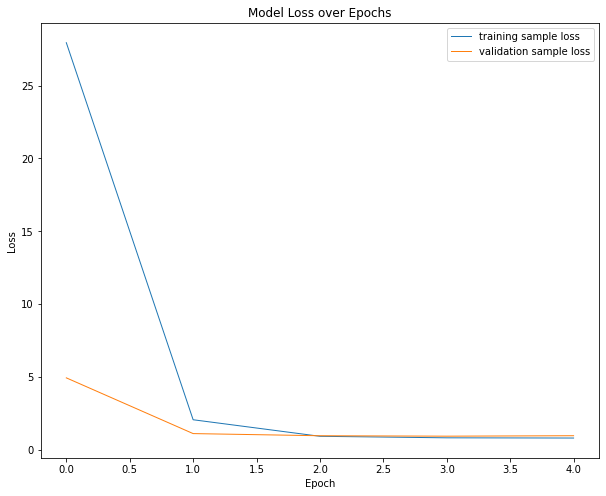

In [11]:
learningCurve(history)

In [12]:
labels_pred = model.predict(test_x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:

def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    #plt.yscale("log")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LBN ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    plt.savefig('5_tag_ROC.png')
    return labels_pred

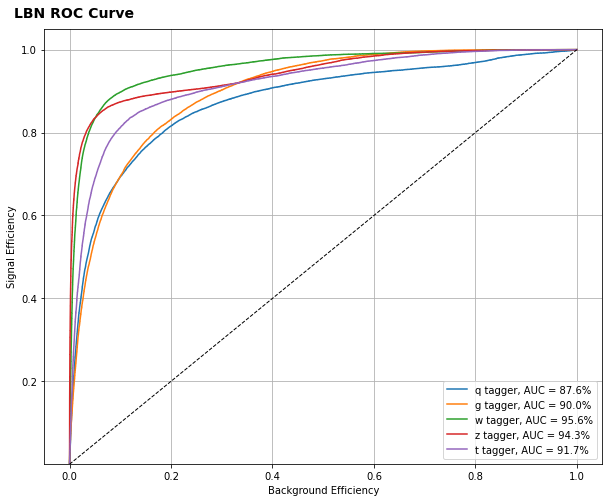

In [14]:
labels = ['j_q', 'j_g', 'j_w', 'j_z', 'j_t']
y_pred = makeRoc(test_x, test_y, labels, model, outputSuffix='lbn-5tag')

In [15]:
input_shape = (50,4)

inputs = keras.Input(shape=input_shape)

x = LBNLayer(input_shape, 50, boost_mode=LBN.PAIRS, features=["E", "pt", "eta", "phi", "m", "pair_cos"])(inputs)

x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc1_elu')(x)
x = BatchNormalization()(x)
x = Dense(512, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc2_elu')(x)
x = BatchNormalization()(x)
x = Dense(256, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc3_elu')(x)
x = BatchNormalization()(x)
x = Dense(128, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc4_elu')(x)
x = BatchNormalization()(x)
outputs = Dense(5, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='softmax', name='output_softmax')(x)

model2 = keras.Model(inputs=inputs, outputs=outputs, name="lbn-model2")

In [16]:
model2.summary()

Model: "lbn-model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 4)]           0         
_________________________________________________________________
LBN (LBNLayer)               (None, 1475)              5000      
_________________________________________________________________
fc1_elu (Dense)              (None, 1024)              1511424   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)              4096      
_________________________________________________________________
fc2_elu (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
fc3_elu (Dense)              (None, 256)               1

In [17]:
adam = Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.2,patience=3,verbose=1)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history2 = model2.fit(train_x, train_y, batch_size = 1024, epochs = 10, 
                    validation_split = 0.11, shuffle = True, callbacks = [reduce_lr],
                    use_multiprocessing= True, workers=4)

Epoch 1/10
773/773 [==============================] - ETA: 0s - loss: 6.5122 - accuracy: 0.7086WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018ED71026A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
773/773 [==============================] - 19s 25ms/step - loss: 6.5122 - accuracy: 0.7086 - val_loss: 1.9730 - val_accuracy: 0.73

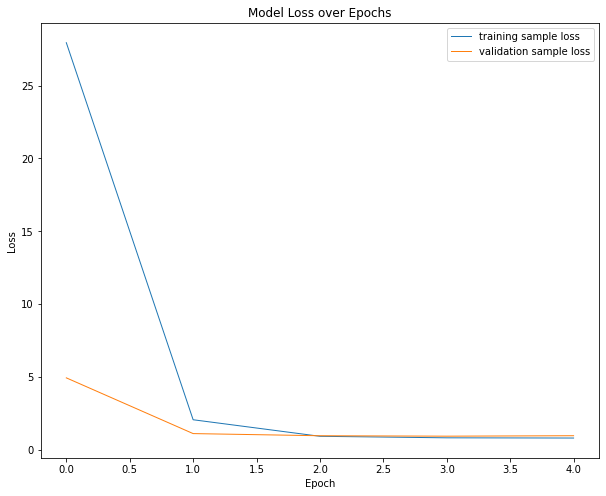

In [20]:
learningCurve(history)

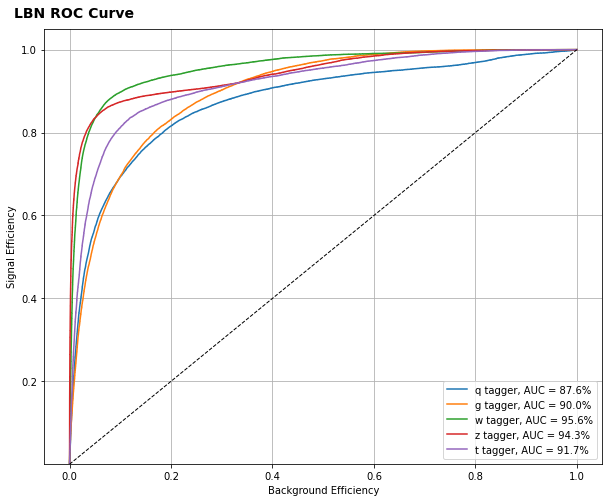

In [21]:
labels = ['j_q', 'j_g', 'j_w', 'j_z', 'j_t']
y_pred = makeRoc(test_x, test_y, labels, model, outputSuffix='lbn-5tag')